- Can we predict more precisely in the future?
- Visualize
- Try other companies - define them
- Find new features (Sentiment)
- Baseline model (https://www.danerwealth.com/blog/the-terrible-track-record-of-wall-street-forecasts)


In [1]:
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV


#!pip install numpy scipy patsy pandas
#!pip install statsmodels
# Time series decomposition
#!pip install stldecompose
#from stldecompose import decompose
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)


In [2]:
import yfinance as yf

# Define the ticker symbol for S&P 500 (SPY is an ETF that tracks the S&P 500)
ticker_symbol = "AMZN"

# Set the start and end dates for the data
start_date = "2020-01-10"  # Replace with your desired start date
end_date = "2024-01-10"    # Replace with your desired end date

# start_date = "2019-08-01"  # Replace with your desired start date
# end_date = "2023-08-01"  


# Use yfinance to download the data
amazon_stock = yf.download(ticker_symbol, start=start_date, end=end_date)

# Display the data
amazon_stock.head()

[*********************100%***********************]  1 of 1 completed


Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2020-01-10  95.268501  95.347000  94.000000  94.157997  94.157997  57074000
2020-01-13  94.565498  94.900002  94.040001  94.565002  94.565002  55616000
2020-01-14  94.293999  94.355499  92.927498  93.472000  93.472000  68818000
2020-01-15  93.612503  93.943001  92.754501  93.100998  93.100998  57932000
2020-01-16  94.149498  94.279503  93.301003  93.897003  93.897003  53190000

In [3]:
import pandas as pd

amazon_stock.index = pd.to_datetime(amazon_stock.index)

# Reset the index to make "Date" a regular column
amazon_stock.reset_index(drop=False, inplace=True)

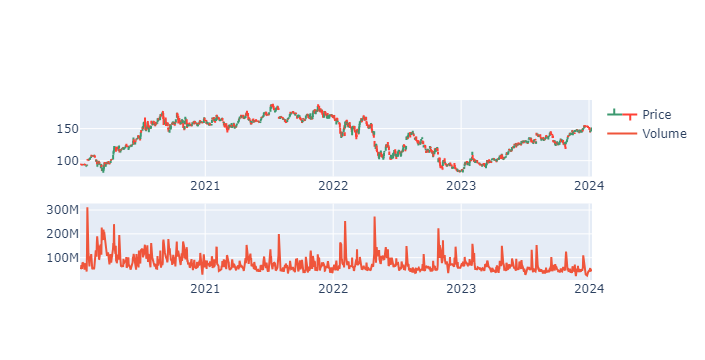

In [4]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=amazon_stock.Date,
                      open=amazon_stock.Open,
                      high=amazon_stock.High,
                      low=amazon_stock.Low,
                      close=amazon_stock.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=amazon_stock.Date, y=amazon_stock.Volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

Using Plotly, this code snippet creates a visual representation of data. To display an OHLC (open/high/low/close) chart and a Volume chart, it generates a figure with two subplots arranged vertically (two rows and one column). 
Using Plotly's go.Ohlc trace type, an OHLC chart is added to the first subplot. OHLC chart x-axis values are taken from the "Date" column of DataFrame "df". DataFrame columns provide the open, high, low, and close values for each data point. As a result, the OHLC chart provides a graphical representation of the price movements over time. 
Using the go.Scatter trace type, a scatter plot is added to the second subplot. The x-axis values are again taken from the "Date" column, while the y-axis values are taken from the "Volume" column. On this Volume chart, the number of stocks traded each day is shown. 
The code updates the layout of the figure after adding the traces to the subplots. Specifically, it hides the x-axis range slider, removing the interactive slider that enables zooming and panning. 
Using the "show()" method, the code displays the generated figure. It allows for the visual analysis and interpretation of historical price and trading volume data using the OHLC chart and Volume chart. 
The code generates a figure with two subplots: an OHLC chart illustrating price movement and a Volume chart showing trading volume. Using the resulting figure, traders can analyze historical price trends and trading activity.

Composition

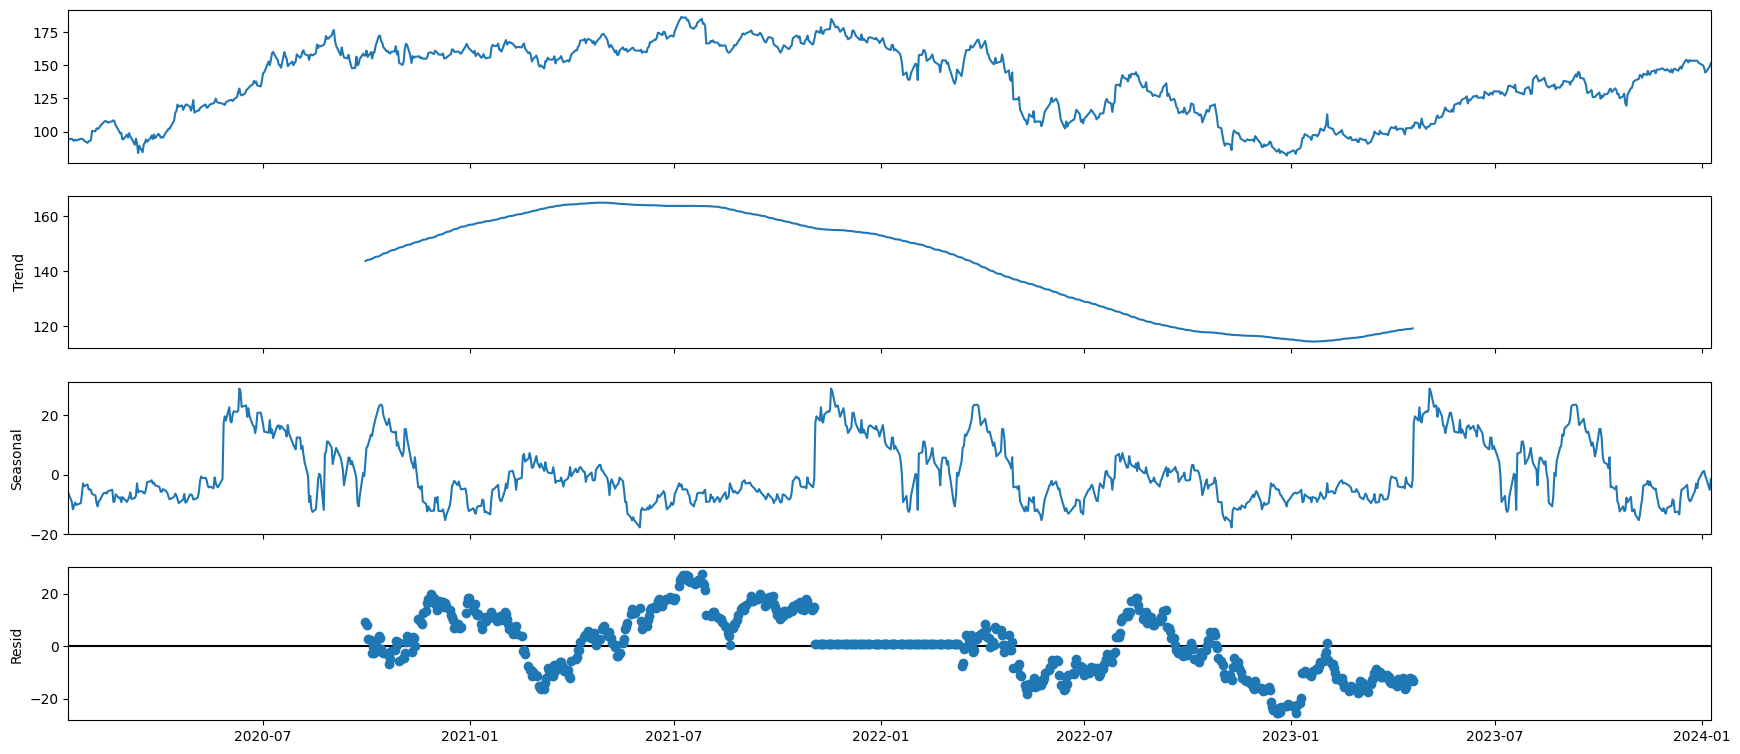

In [5]:
df_close = amazon_stock[['Date', 'Close']].copy()
df_close = df_close.set_index('Date')
df_close.head()

decomp = seasonal_decompose(df_close, period=365)
fig = decomp.plot()
fig.set_size_inches(20, 8)

The code in this section performs a time series decomposition and generates a plot showing the decomposed components. 

By selecting only the "Date" and "Close" columns from the original DataFrame "df", a new DataFrame called "df_close" is created. Copy() creates a new copy of the DataFrame. In order to facilitate time-based operations, the "df_close" DataFrame is set to have the "Date" column as its index. 
The "seasonal_decompose()" function is then applied to the "df_close" DataFrame. It decomposes the time series data into four components: trend, seasonality, residuals, and observations. By decomposing the data, underlying patterns and fluctuations can be revealed. 
Using the "plot()" method of the decomposed object, the code generates a plot of the decomposed components. This plot shows the original time series along with the trend, seasonality, and residual components. 
The "set_size_inches()" method is used to adjust the size of the figure, setting the width to 20 inches and height to 8 inches. 
Essentially, this code performs time series decomposition on "Close" prices, generating a plot that displays trend, seasonality, and residual components. Time series data are visualized in this way to help understand underlying patterns and fluctuations.

As technical indicators, I compute several moving averages in this code. Specifically, I calculate Simple Moving Averages (SMA) for periods of 5, 10, 15, and 30, as well as Exponential Moving Averages (EMA) for periods of 9 and 12. 

In technical analysis, moving averages are used to smooth out price data and identify trends. A Simple Moving Average is calculated by adding up the closing prices over a specified number of periods and dividing by the number of periods. To obtain multiple moving averages, this calculation is repeated for different periods. 
On the other hand, the Exponential Moving Average assigns different weights to prices based on their recency. Compared to the Simple Moving Average, it responds faster to price changes due to the weighting of recent data points. 
These moving averages allow us to capture different aspects of price trends and fluctuations over time. Based on the observed patterns, these indicators can be used to analyze historical data and potentially make predictions or decisions.

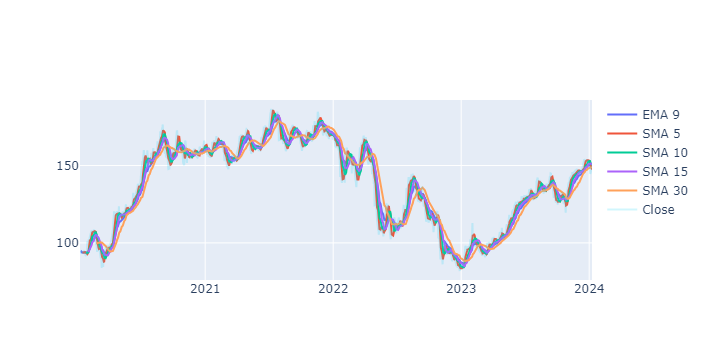

In [6]:
# Creating technical indicators
amazon_stock['EMA_9'] = ta.ema(amazon_stock['Close'], length=9, fillna=True).shift()
amazon_stock['SMA_5'] = ta.sma(amazon_stock['Close'], length=5, fillna=True).shift()
amazon_stock['SMA_10'] = ta.sma(amazon_stock['Close'], length=10, fillna=True).shift()
amazon_stock['SMA_15'] = ta.sma(amazon_stock['Close'], length=15, fillna=True).shift()
amazon_stock['SMA_30'] = ta.sma(amazon_stock['Close'], length=30, fillna=True).shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=amazon_stock.Date, y=amazon_stock.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=amazon_stock.Date, y=amazon_stock.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=amazon_stock.Date, y=amazon_stock.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=amazon_stock.Date, y=amazon_stock.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=amazon_stock.Date, y=amazon_stock.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=amazon_stock.Date, y=amazon_stock.Close, name='Close', opacity=0.2))
fig.show()

Using the provided dataset, this code calculates and visualizes various technical indicators. 
Using the closing prices from the dataset, the code calculates the Exponential Moving Average (EMA) with a period of 9. The exponentially weighted moving average (ewm) assigns more weight to recent prices when computing the EMA. To align the EMA values with the corresponding dates, the values are first shifted by one period. 
Using the rolling mean function (rolling), the code calculates Simple Moving Averages (SMA) for different periods (5, 10, 15, and 30). In the rolling mean, the closing prices over a specific period or window are averaged. As with the EMA, the SMA values are also shifted by one period. 
Using the Plotly library, the code generates a plot using the moving averages. An empty figure is used as the plot's initialization. Multiple traces (lines) are then added to the figure, each representing a different moving average or the original closing price. The x-axis represents the dataset dates, while the y-axis represents the corresponding moving averages or closing prices. 
The plot is displayed using the "show()" method, allowing visual examination and analysis of the moving averages alongside the original closing prices. 
Using the provided dataset, this code calculates and visualizes various moving averages (EMA and SMA). Plotting these moving averages provides insight into trends and patterns in the data.

The Relative Strength Index (RSI) indicator will be used to determine whether a stock is overbought or oversold. 

In order to determine if a stock is overextended, the RSI measures the magnitude of recent price changes. In addition, it provides insight into the stock's current strength and potential reversal points. 
I can determine whether a stock is overbought or oversold by calculating the RSI. The RSI value above a certain threshold (typically 70) indicates overbought conditions, indicating a potential price correction or reversal. A value below another threshold (usually 30) indicates the stock is oversold, indicating a potential buying opportunity. 
By incorporating the RSI indicator into the analysis, it is possible to better understand the stock's current market conditions and potential trading opportunities. Making informed decisions about an overbought or oversold stock aids in predicting potential price movements.

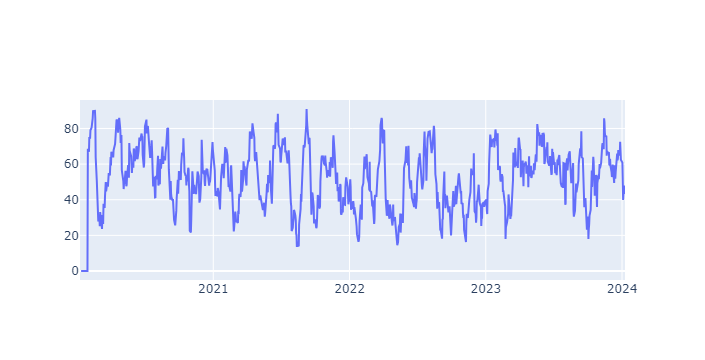

In [7]:
def relative_strength_idx(df, n=14):
    close = amazon_stock['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

amazon_stock['RSI'] = relative_strength_idx(amazon_stock).fillna(0)

fig = go.Figure(go.Scatter(x=amazon_stock.Date, y=amazon_stock.RSI, name='RSI'))
fig.show()

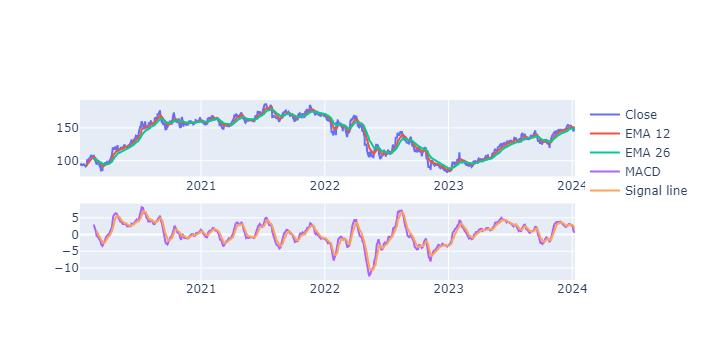

In [8]:
EMA_12 = pd.Series(amazon_stock['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(amazon_stock['Close'].ewm(span=26, min_periods=26).mean())
amazon_stock['MACD'] = pd.Series(EMA_12 - EMA_26)
amazon_stock['MACD_signal'] = pd.Series(amazon_stock.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=amazon_stock.Date, y=amazon_stock.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=amazon_stock.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=amazon_stock.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=amazon_stock.Date, y=amazon_stock['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=amazon_stock.Date, y=amazon_stock['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

In [9]:
amazon_stock['close_tmr'] = amazon_stock['Close'].shift(-1)
amazon_stock['close_today'] = amazon_stock['Close']

In [10]:
amazon_stock['OBV'] = (amazon_stock['Volume'] * ((amazon_stock['close_today'] - amazon_stock['close_today'].shift(1)) > 0)).cumsum()
amazon_stock['ROC'] = amazon_stock['Close'].pct_change() * 100  # Calculate percentage change


In [11]:
amazon_stock

Date        Open        High         Low       Close   Adj Close   
0    2020-01-10   95.268501   95.347000   94.000000   94.157997   94.157997  \
1    2020-01-13   94.565498   94.900002   94.040001   94.565002   94.565002   
2    2020-01-14   94.293999   94.355499   92.927498   93.472000   93.472000   
3    2020-01-15   93.612503   93.943001   92.754501   93.100998   93.100998   
4    2020-01-16   94.149498   94.279503   93.301003   93.897003   93.897003   
...         ...         ...         ...         ...         ...         ...   
1001 2024-01-03  149.199997  151.050003  148.330002  148.470001  148.470001   
1002 2024-01-04  145.589996  147.380005  144.050003  144.570007  144.570007   
1003 2024-01-05  144.690002  146.589996  144.529999  145.240005  145.240005   
1004 2024-01-08  146.740005  149.399994  146.149994  149.100006  149.100006   
1005 2024-01-09  148.330002  151.710007  148.210007  151.369995  151.369995   

        Volume       EMA_9       SMA_5      SMA_10      SMA_15      SMA_30   
0     57074000         NaN         NaN         NaN         NaN         NaN  \
1     55616000   94.157997         NaN         NaN         NaN         NaN   
2     68818000   94.372210         NaN         NaN         NaN         NaN   
3     57932000   94.040030         NaN         NaN         NaN         NaN   
4     53190000   93.766976         NaN         NaN         NaN         NaN   
...        ...         ...         ...         ...         ...         ...   
1001  49425500  150.366798  152.400000  152.923999  151.255999  148.741333   
1002  56039800  150.177118  151.412000  152.363998  151.427999  148.851000   
1003  45124800  149.616407  149.658002  151.442000  151.234000  148.799000   
1004  46757100  149.178767  148.030002  150.754001  150.994000  148.843667   
1005  43812600  149.170891  147.462003  150.280002  151.106001  148.923334   

            RSI      MACD  MACD_signal   close_tmr  close_today          OBV   
0           NaN       NaN          NaN   94.565002    94.157997            0  \
1      0.000000       NaN          NaN   93.472000    94.565002     55616000   
2      0.000000       NaN          NaN   93.100998    93.472000     55616000   
3      0.000000       NaN          NaN   93.897003    93.100998     55616000   
4      0.000000       NaN          NaN   93.236000    93.897003    108806000   
...         ...       ...          ...         ...          ...          ...   
1001  52.668474  2.005641     2.660283  144.570007   148.470001  39150940600   
1002  39.876758  1.341140     2.396454  145.240005   144.570007  39150940600   
1003  44.641126  0.858684     2.088900  149.100006   145.240005  39196065400   
1004  47.990776  0.778825     1.826885  151.369995   149.100006  39242822500   
1005  43.188670  0.888464     1.639201         NaN   151.369995  39286635100   

           ROC  
0          NaN  
1     0.432258  
2    -1.155821  
3    -0.396913  
4     0.854991  
...        ...  
1001 -0.973782  
1002 -2.626789  
1003  0.463442  
1004  2.657670  
1005  1.522461  

[1006 rows x 19 columns]

This code removes invalid samples from the dataset to ensure data integrity and accuracy. 

A number of rows may contain invalid values as a result of the calculation of moving averages and the shifting of the label column. Since there are insufficient preceding data points, the SMA10 (Simple Moving Average with a period of 10) may not be valid for the first 10 rows. The last row's price may also be erroneously set to 0 after shifting the Close price column. 
The dataset is cleansed of any data points that may cause inconsistencies or misinterpretations when these invalid samples are removed. The purpose of this step is to maintain the accuracy and reliability of the data for analysis or modeling in the future. 
The code identifies and removes invalid samples from the dataset, including rows with incomplete moving average calculations and the last row with an incorrect Close price. In this way, the dataset's integrity is ensured and the analysis is more reliable.

In [12]:
amazon_stock = amazon_stock.iloc[33:] # Because of moving averages and MACD line
amazon_stock = amazon_stock[:-1]      # Because of shifting close price

amazon_stock.index = range(len(amazon_stock))

In [13]:
amazon_stock.tail()

Date        Open        High         Low       Close   Adj Close   
967 2024-01-02  151.539993  152.380005  148.389999  149.929993  149.929993  \
968 2024-01-03  149.199997  151.050003  148.330002  148.470001  148.470001   
969 2024-01-04  145.589996  147.380005  144.050003  144.570007  144.570007   
970 2024-01-05  144.690002  146.589996  144.529999  145.240005  145.240005   
971 2024-01-08  146.740005  149.399994  146.149994  149.100006  149.100006   

       Volume       EMA_9       SMA_5      SMA_10      SMA_15      SMA_30   
967  47339400  150.415332  153.098001  152.928000  151.088666  148.504667  \
968  49425500  150.366798  152.400000  152.923999  151.255999  148.741333   
969  56039800  150.177118  151.412000  152.363998  151.427999  148.851000   
970  45124800  149.616407  149.658002  151.442000  151.234000  148.799000   
971  46757100  149.178767  148.030002  150.754001  150.994000  148.843667   

           RSI      MACD  MACD_signal   close_tmr  close_today          OBV   
967  60.813664  2.427522     2.823944  148.470001   149.929993  39150940600  \
968  52.668474  2.005641     2.660283  144.570007   148.470001  39150940600   
969  39.876758  1.341140     2.396454  145.240005   144.570007  39150940600   
970  44.641126  0.858684     2.088900  149.100006   145.240005  39196065400   
971  47.990776  0.778825     1.826885  151.369995   149.100006  39242822500   

          ROC  
967 -1.322897  
968 -0.973782  
969 -2.626789  
970  0.463442  
971  2.657670

In [14]:
amazon_stock['Year'] = amazon_stock['Date'].dt.year
amazon_stock['Month'] = amazon_stock['Date'].dt.month
amazon_stock['Day'] = amazon_stock['Date'].dt.day

In [15]:
# # Load in sentiment
# df_sentiment_amz = pd.read_csv('aggregated_df_onehot.csv')

In [16]:
# df_sentiment_amz['Date'] = pd.to_datetime(df_sentiment_amz['date'])  # Convert 'date' column to datetime
# merged_df = amazon_stock.merge(df_sentiment_amz, how='left', on='Date')
# # Display the resulting merged DataFrame
# merged_df

In [17]:
# amazon_stock['Sentiment_Negative_Probability'] = merged_df['Sentiment_Negative_Probability'].fillna(method='ffill')
# amazon_stock['Sentiment_Neutral_Probability'] = merged_df['Sentiment_Neutral_Probability'].fillna(method='ffill')
# amazon_stock['Sentiment_Positive_Probability'] = merged_df['Sentiment_Positive_Probability'].fillna(method='ffill')

In [18]:
# # Fill remaining NaN values with 'Neutral'
# merged_df['Sentiment_Negative_Probability'].fillna(False, inplace=True)
# merged_df['Sentiment_Neutral_Probability'].fillna(True, inplace=True)
# merged_df['Sentiment_Positive_Probability'].fillna(False, inplace=True)

In [19]:
# test_size  = 0.15
# valid_size = 0.15

# test_split_idx  = int(amazon_stock.shape[0] * (1-test_size))
# valid_split_idx = int(amazon_stock.shape[0] * (1-(valid_size+test_size)))

# train_df  = amazon_stock.loc[:valid_split_idx].copy()
# valid_df  = amazon_stock.loc[valid_split_idx+1:test_split_idx].copy()
# test_df   = amazon_stock.loc[test_split_idx+1:].copy()

# fig = go.Figure()
# fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
# fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
# fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))
# fig.show()

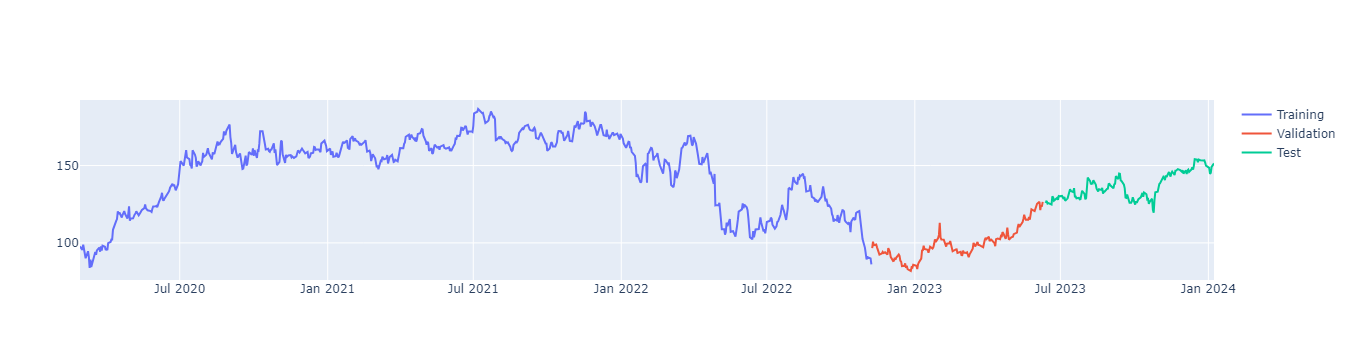

In [20]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(amazon_stock.shape[0] * (1-test_size))
valid_split_idx = int(amazon_stock.shape[0] * (1-(valid_size+test_size)))

train_df = amazon_stock.loc[:valid_split_idx].copy()
valid_df = amazon_stock.loc[valid_split_idx+1:test_split_idx].copy()
test_df = amazon_stock.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.close_tmr, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.close_tmr, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.close_tmr,  name='Test'))
fig.show()

In [21]:
# drop_cols = ['Date', 'Open', 'Low', 'High', 'Adj Close', 'Volume', 'OBV', 'ROC']  # Date, Open, High, Low, Close, Volume, OpenInt

# # Assuming train_df, valid_df, and test_df are your DataFrames
# train_df_sent = train_df_sent.drop(columns=drop_cols)
# valid_df_sent = valid_df_sent.drop(columns=drop_cols)
# test_df_sent = test_df_sent.drop(columns=drop_cols)

In [22]:
drop_cols = ['Open', 'High', 'Low','Date', 'Adj Close', 'Volume', 'Close', 'ROC', 'OBV']  # Date,  Close, Volume, OpenInt

# Assuming train_df, valid_df, and test_df are your DataFrames
train_df = train_df.drop(columns=drop_cols)
valid_df = valid_df.drop(columns=drop_cols)
test_df = test_df.drop(columns=drop_cols)

In [23]:
# Making copies
train_df_scaled = train_df.copy()
test_df_scaled = test_df.copy()

In [24]:
from sklearn.preprocessing import MinMaxScaler

# Assuming df is your DataFrame with the features you want to scale
columns_to_scale = ['EMA_9', 'SMA_5', 'SMA_10', 'SMA_15', 'SMA_30', 'RSI', 'MACD', 'MACD_signal', 'close_tmr', 'close_today']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the selected columns and transform the data
train_df_scaled[columns_to_scale] = scaler.fit_transform(train_df[columns_to_scale])
test_df_scaled[columns_to_scale] = scaler.transform(test_df[columns_to_scale])

Labels and features

In [25]:
y_train = train_df['close_tmr'].copy()
X_train = train_df.drop(['close_tmr'], axis=1)  # Drop both 'Close' and 'Adj Close'

y_train_scaled = train_df_scaled['close_tmr'].copy()
X_train_scaled = train_df_scaled.drop(['close_tmr'], axis=1)  # Drop both 'Close' and 'Adj Close'

y_valid = valid_df['close_tmr'].copy()
X_valid = valid_df.drop(['close_tmr'], axis=1)  # Drop both 'Close' and 'Adj Close'

y_test  = test_df['close_tmr'].copy()
X_test  = test_df.drop(['close_tmr'], axis=1)  # Drop both 'Close' and 'Adj Close'

y_test_scaled  = test_df_scaled['close_tmr'].copy()
X_test_scaled  = test_df_scaled.drop(['close_tmr'], axis=1)  # Drop both 'Close' and 'Adj Close'

X_train.isna().sum()

EMA_9          0
SMA_5          0
SMA_10         0
SMA_15         0
SMA_30         0
RSI            0
MACD           0
MACD_signal    0
close_today    0
Year           0
Month          0
Day            0
dtype: int64

In [26]:
y_test

827    126.660004
828    126.419998
829    127.110001
830    125.489998
831    125.779999
          ...    
967    148.470001
968    144.570007
969    145.240005
970    149.100006
971    151.369995
Name: close_tmr, Length: 145, dtype: float64

In [27]:
# from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor


# # Create a smaller parameter grid
# param_dist = {
#     'n_estimators': [50, 100, 150, 200, 250],
#     'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
#     'max_depth': [5, 8, 10, 12, 15],
#     'gamma': [0.001, 0.005, 0.01, 0.02, 0.05],
#     'random_state': [42]
# }

# xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# # Create RandomizedSearchCV object
# random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist,
#                                    scoring='neg_mean_squared_error', n_iter=5, cv=3, random_state=42)

# # Fit the model with the random parameter search using the smaller dataset
# random_search.fit(X_train, y_train)

# # Get the best parameters from the random search
# best_params_random = random_search.best_params_
# print(f'Best Parameters (Randomized Search): {best_params_random}')

# # Get the best model from the random search
# best_xgb_model_random = random_search.best_estimator_

# Set the parameters
gamma_val = 0.01
learning_rate_val = 0.01
max_depth_val = 5
n_estimators_val = 300
random_state_val = 42

# Create the XGBRegressor with the specified parameters
xgb_reg = XGBRegressor(
    gamma=gamma_val,
    learning_rate=learning_rate_val,
    max_depth=max_depth_val,
    n_estimators=n_estimators_val,
    random_state=random_state_val
)

xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.01, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [28]:
import numpy as np
# Make predictions on the test set
y_test_pred = xgb_reg.predict(X_test)

# Evaluate the model on the test set
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
print(f'Test RMSE: {rmse_test}')

Test RMSE: 3.0310523257083086


In [29]:
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# Calculate MAPE on the test set
mape_test = calculate_mape(y_test, y_test_pred)
print(f'Test MAPE: {mape_test:.2f}%')

Test MAPE: 1.80%


In [30]:
import numpy as np
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_test_pred[:5]}')

y_true = [126.66000366 126.41999817 127.11000061 125.48999786 125.77999878]
y_pred = [129.63722 129.63722 129.61322 130.40239 125.13908]


In [31]:
from sklearn.metrics import accuracy_score, classification_report

k = 7 # Set the number of days to predict ahead

# Convert regression predictions to binary labels (1 for price up, 0 for price down)
predicted_direction = np.where(y_test_pred[k:] > y_test_pred[:-k], 1, 0)

# Create true binary labels based on the actual price movements
true_direction = np.where(y_test.values[k:] > y_test.values[:-k], 1, 0)


# Calculate accuracy and other classification metrics
accuracy = accuracy_score(true_direction, predicted_direction)
classification_report_result = classification_report(true_direction, predicted_direction)


print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report_result)

Accuracy: 0.782608695652174
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.79      0.73        52
           1       0.86      0.78      0.82        86

    accuracy                           0.78       138
   macro avg       0.77      0.78      0.77       138
weighted avg       0.79      0.78      0.79       138



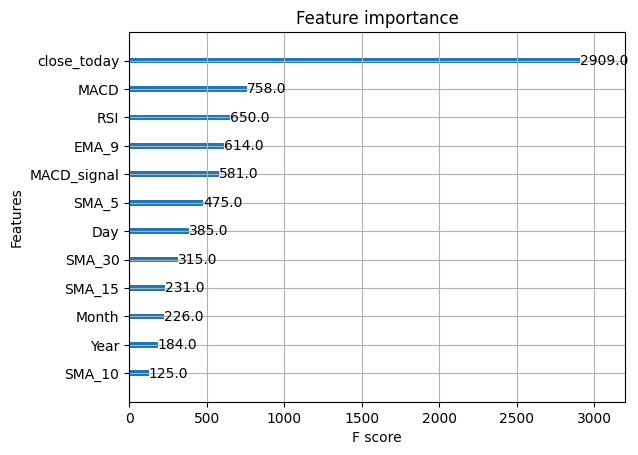

In [32]:
plot_importance(xgb_reg);

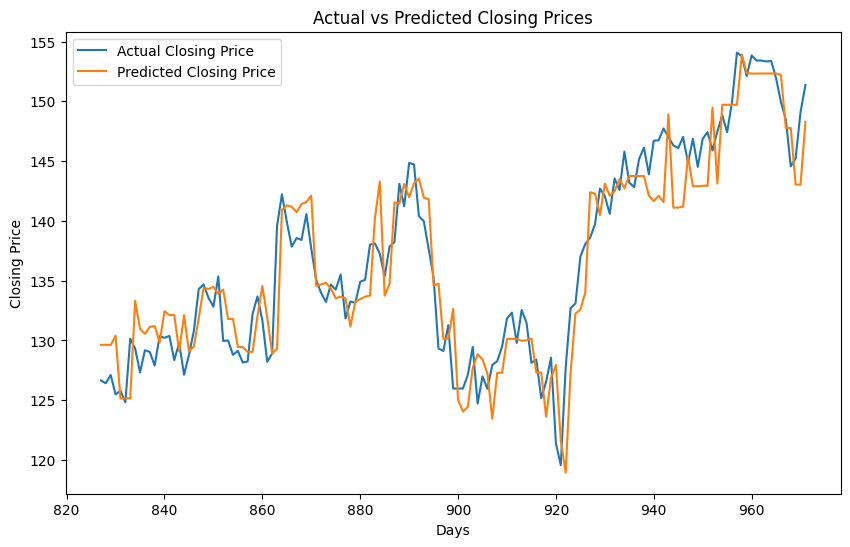

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot actual closing prices
plt.plot(y_test.index, y_test.values, label='Actual Closing Price')

# Plot predicted closing prices
plt.plot(y_test.index, y_test_pred, label='Predicted Closing Price')

plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Prices')
plt.legend()
plt.show()